In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/m5-forecasting-accuracy/calendar.csv
/kaggle/input/m5-forecasting-accuracy/sample_submission.csv
/kaggle/input/m5-forecasting-accuracy/sell_prices.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install japanize-matplotlib
import japanize_matplotlib
import warnings
warnings.filterwarnings("ignore")

def reduce_memory_usage(df):
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:  # 数値型の場合
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
        else:
            # 文字列はcategory型に変換
            df[col] = df[col].astype('category')
    return df

In [6]:
# M5コンペのデータを読み込み、reduce_memory_usage関数でメモリ効率を最適化
calendar = reduce_memory_usage(pd.read_csv("/kaggle/input/m5-forecasting-accuracy/calendar.csv"))
sell_prices = reduce_memory_usage(pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sell_prices.csv"))
sub = reduce_memory_usage(pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sample_submission.csv"))
sales_train = reduce_memory_usage(pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv"))
sales_valid =reduce_memory_usage(pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv"))

In [7]:
#カレンダーデータの表示
calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [8]:
#販売価格の表示
sell_prices

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125
2,CA_1,HOBBIES_1_001,11327,8.257812
3,CA_1,HOBBIES_1_001,11328,8.257812
4,CA_1,HOBBIES_1_001,11329,8.257812
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.000000
6841117,WI_3,FOODS_3_827,11618,1.000000
6841118,WI_3,FOODS_3_827,11619,1.000000
6841119,WI_3,FOODS_3_827,11620,1.000000


In [9]:
#訓練データの表示
sales_train

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,1,0,3,0,1,1,0,0,1,1
30486,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
30487,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,0,0,1,2,0,1,0,1,0,2
30488,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,1,1,1,4,6,0,1,1,1,0


In [10]:
#提出用データの表示
sub

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60976,FOODS_3_824_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60977,FOODS_3_825_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60978,FOODS_3_826_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# ID関連の列名をリストで定義（melt処理時に保持するため）
id_cols = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
# wide形式（列がd_1, d_2,...の日付）の売上データをlong形式に変換
# 各行が「商品 × 日付 × 売上」になる形式に整形
sales_train_long = sales_train.melt(id_vars=id_cols, var_name='d', value_name='sales')
# 'd_1' → '1' に変換し、整数型にキャスト（日付として扱いやすくする）
sales_train_long['d'] = sales_train_long['d'].str.replace('d_', '').astype(int)

In [12]:
#long形式に変換した売上データを表示
sales_train_long

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1,0
...,...,...,...,...,...,...,...,...
59181085,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1941,1
59181086,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,1941,0
59181087,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,1941,2
59181088,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,1941,0


In [13]:
# 売上データ（sales列）の基本統計量を表示
sales_train_long['sales'].describe()

count    5.918109e+07
mean     1.130888e+00
std      3.870038e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      7.630000e+02
Name: sales, dtype: float64

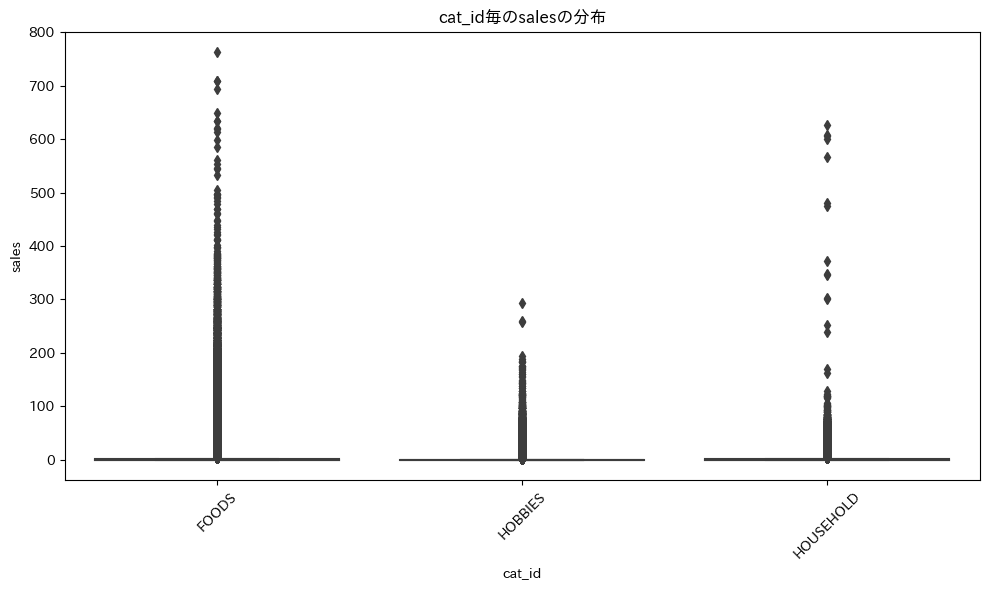

In [14]:
# グラフサイズを設定
plt.figure(figsize=(10,6))
# 商品カテゴリ（cat_id）ごとの売上（sales）の分布を箱ひげ図で可視化
sns.boxplot(x='cat_id',y='sales',data=sales_train_long)
# グラフのタイトルと軸ラベルを設定
plt.title('cat_id毎のsalesの分布')
plt.xlabel('cat_id')
plt.ylabel('sales')
# x軸ラベルが重ならないように回転
plt.xticks(rotation=45)
# レイアウトの自動調整
plt.tight_layout()
# グラフを表示
plt.show()

In [15]:
# カレンダーデータの'd'列の文字列 "d_XXXX" を整数型に変換（例："d_1" → 1）
calendar['d'] = calendar['d'].str.replace('d_','').astype(int)

# calendarの一部列（日時情報やイベント）を sales_train_long にマージ
# 主キー：日数インデックス 'd'
sales_train_long = sales_train_long.merge(calendar[['d','date','wday','month','year','event_name_1','event_type_1','event_name_2','event_type_2','wm_yr_wk']],on='d',how='left')

# 売価データをマージ。キーは store_id, item_id, wm_yr_wk
# 各商品の週ごとの販売価格（sell_price）を追加
sales_train_long = sales_train_long.merge(sell_prices, on=['store_id','item_id','wm_yr_wk'], how='left')

In [16]:
#売上データを表示
sales_train_long

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,wm_yr_wk,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,1,1,2011,NaN,NaN,NaN,NaN,11101,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,1,1,2011,NaN,NaN,NaN,NaN,11101,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,1,1,2011,NaN,NaN,NaN,NaN,11101,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,1,1,2011,NaN,NaN,NaN,NaN,11101,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,1,1,2011,NaN,NaN,NaN,NaN,11101,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59181085,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1941,1,2016-05-22,2,5,2016,NaN,NaN,NaN,NaN,11617,2.980469
59181086,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,1941,0,2016-05-22,2,5,2016,NaN,NaN,NaN,NaN,11617,2.480469
59181087,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,1941,2,2016-05-22,2,5,2016,NaN,NaN,NaN,NaN,11617,3.980469
59181088,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,1941,0,2016-05-22,2,5,2016,NaN,NaN,NaN,NaN,11617,1.280273


In [17]:
# 'date'列をdatetime型に変換
sales_train_long['date'] = pd.to_datetime(sales_train_long['date'])

# 州(state_id)、年(year)、月(month)ごとに集計
# - 'sales'列の合計（その月の売上）
# - 'date'列の最小値（月の最初の日）を取得
bar = sales_train_long.groupby(['state_id', 'year', 'month']).agg({
    'sales': 'sum',
    'date': 'min'
}).reset_index()

In [18]:
# 月初の日付のみを抽出（date列の日付が1日のものだけを残す）
bar = bar[bar['date'].dt.day == 1]

# 最大日付（最新の月初）を取得
max_date = bar['date'].max()

# 最新月のデータを除外
bar = bar[bar['date'] != max_date]

In [19]:
#barデータを表示
bar

,state_id,year,month,sales,date
1,CA,2011,2,318101,2011-02-01
2,CA,2011,3,339678,2011-03-01
3,CA,2011,4,331004,2011-04-01
4,CA,2011,5,321566,2011-05-01
5,CA,2011,6,332948,2011-06-01
...,...,...,...,...,...
203,WI,2015,12,340698,2015-12-01
204,WI,2016,1,368104,2016-01-01
205,WI,2016,2,379113,2016-02-01
206,WI,2016,3,393142,2016-03-01


In [20]:
# Plotlyのインポートと描画設定
import plotly.express as px
import plotly.io as pio

# 州（state_id）ごとの月次売上を折れ線グラフで可視化
fig = px.line(bar, x='date', y='sales', color='state_id',title='Monthly Sales per State')
# 軸ラベルの設定
fig.update_layout(xaxis_title='Date', yaxis_title='Sales')
# グラフの表示
fig.show()

In [21]:
# 'cat_id'ごとの出現回数をカウントして、データフレームに変換
category_counts = sales_train_long['cat_id'].value_counts().reset_index()

# 列名の設定：'cat_id'（カテゴリID）と'count'（出現回数）
category_counts.columns = ['cat_id', 'count']

# 結果を表示
category_counts

,cat_id,count
0,FOODS,27892170
1,HOUSEHOLD,20322270
2,HOBBIES,10966650


In [22]:
# カテゴリごとの出現回数（count）を棒グラフで可視化
fig2 = px.bar(category_counts, x='cat_id', y='count', title='Rows per Category', color='cat_id')
# グラフの表示
fig2.show()

In [23]:
# 価格データが欠損している行を抽出
sales_when_no_price = sales_train_long[sales_train_long['sell_price'].isna()]

# 価格データが欠損している行の売上（sales）の統計量を表示
sales_when_no_price['sales'].describe()

count    12299413.0
mean            0.0
std             0.0
min             0.0
25%             0.0
50%             0.0
75%             0.0
max             0.0
Name: sales, dtype: float64

In [24]:
# 'date'列を日時型に変換
sales_train_long['date'] = pd.to_datetime(sales_train_long['date'])

# 'cat_id'（カテゴリID）と'wm_yr_wk'（週ごとの年月）でグループ化
# 各グループに対して、売上（sales）の合計、最初の日付（date）、平均売価（sell_price）を集計
bar_2 = sales_train_long.groupby(['cat_id', 'wm_yr_wk']).agg({
    'sales':'sum',
    'date': 'min',
    'sell_price':'mean'
}).reset_index()

In [25]:
#bar_2を表示
bar_2

,cat_id,wm_yr_wk,sales,date,sell_price
0,FOODS,11101,139174,2011-01-29,2.957933
1,FOODS,11102,142510,2011-02-05,2.994420
2,FOODS,11103,131518,2011-02-12,3.000529
3,FOODS,11104,114527,2011-02-19,3.001498
4,FOODS,11105,123171,2011-02-26,2.997889
...,...,...,...,...,...
829,HOUSEHOLD,11613,69148,2016-04-23,5.472789
830,HOUSEHOLD,11614,72605,2016-04-30,5.472290
831,HOUSEHOLD,11615,68133,2016-05-07,5.468792
832,HOUSEHOLD,11616,72563,2016-05-14,5.469906


In [26]:
# 'bar_2'データフレームを使用して、カテゴリごとの週次の売価（sell_price）の推移を可視化
fig = px.line(bar_2, x='date', y='sell_price', color='cat_id',title='Week Sell_price per cat') 
# 軸ラベルの設定
fig.update_layout(xaxis_title='Date', yaxis_title='Sell_price') 
# グラフの表示
fig.show()

In [27]:
# 'bar_2'データフレームを使用して、カテゴリごとの週次の売上（sales）の推移を可視化
fig = px.line(bar_2, x='date', y='sales', color='cat_id',title='Week Sales per cat') 
# 軸ラベルの設定
fig.update_layout(xaxis_title='Date', yaxis_title='Sales') 
# グラフの表示
fig.show()

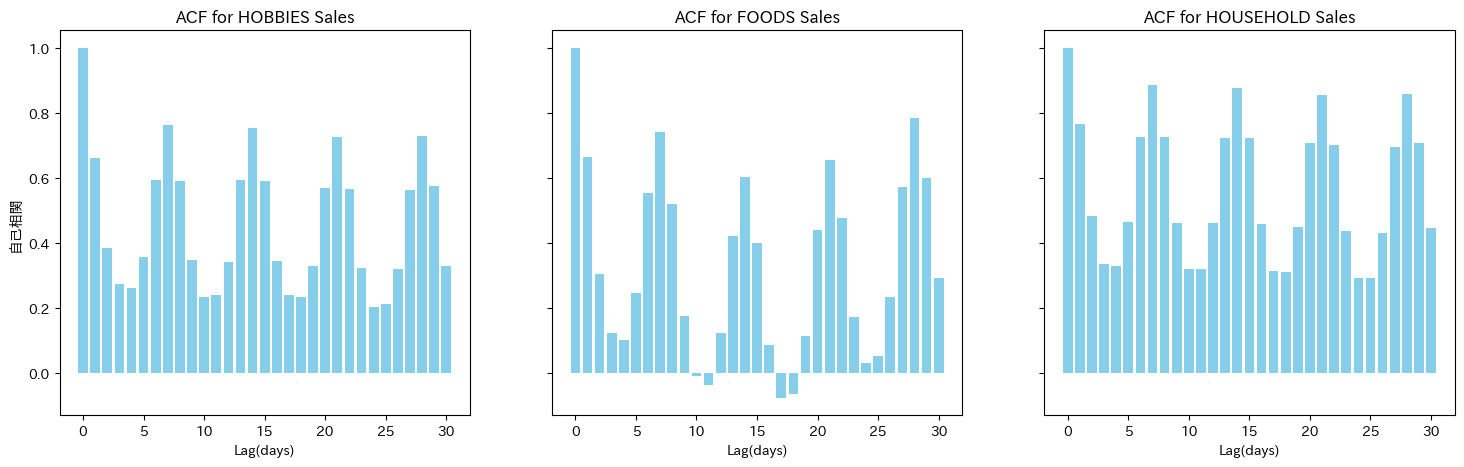

In [28]:
# 必要なライブラリのインポート
from statsmodels.tsa.stattools import acf

# `sales_train_long` から `cat_id` ごとの売上データを集計
df = sales_train_long.groupby(['date', 'cat_id'])['sales'].sum().reset_index()

# 分析対象のカテゴリ
categories = ['HOBBIES','FOODS','HOUSEHOLD']
lags= 30

#グラフ描画の準備
fig, axes = plt.subplots(1,3, figsize=(18,5), sharey=True)

# 各カテゴリに対する自己相関を計算し、プロット
for i, category in enumerate(categories):
    df_cat = df[df['cat_id'] == category].set_index('date')
    #自己相関を計算
    acf_values = acf(df_cat['sales'], nlags=lags, fft=True)
    #自己相関のプロット
    axes[i].bar(range(len(acf_values)), acf_values, color='skyblue')
    axes[i].set_xlabel("Lag(days)")
    axes[i].set_title(f"ACF for {category} Sales")
    
# Y軸ラベルの設定
axes[0].set_ylabel("自己相関")

# レイアウトを調整して表示
plt.tight_layout
plt.show()

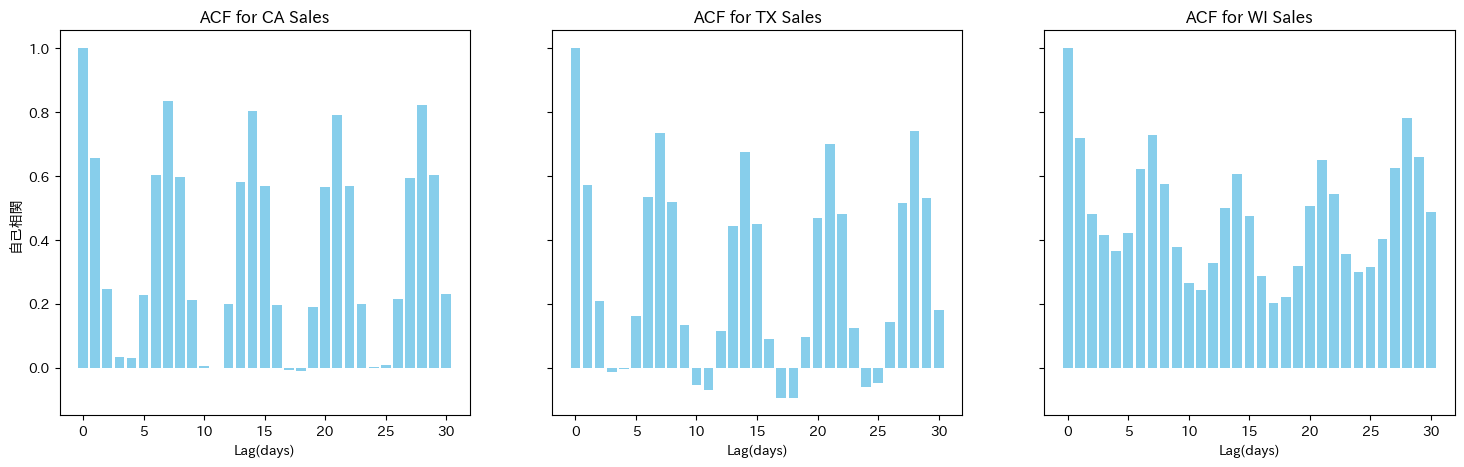

In [29]:
# `state_id` ごとの売上を集計
df_2 = sales_train_long.groupby(['date','state_id'])['sales'].sum().reset_index()

#分析対象の州
categories = ['CA','TX','WI']
lags= 30

#グラフ描画の準備
fig, axes = plt.subplots(1,3, figsize=(18,5), sharey=True)

# 各州に対する自己相関を計算し、プロット
for i, category in enumerate(categories):
    df_state = df_2[df_2['state_id']== category].set_index('date')
    acf_values = acf(df_state['sales'], nlags=lags,fft=True)
    axes[i].bar(range(len(acf_values)), acf_values, color='skyblue')
    axes[i].set_xlabel("Lag(days)")
    axes[i].set_title(f"ACF for {category} Sales")
    
# Y軸ラベルの設定
axes[0].set_ylabel("自己相関")

# レイアウトを調整して表示
plt.tight_layout
plt.show() 

In [30]:
#'dept_id'のuniqueな値の確認
sales_train_long['dept_id'].unique()

['HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS_1', 'FOODS_2', 'FOODS_3']
Categories (7, object): ['FOODS_1', 'FOODS_2', 'FOODS_3', 'HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2']

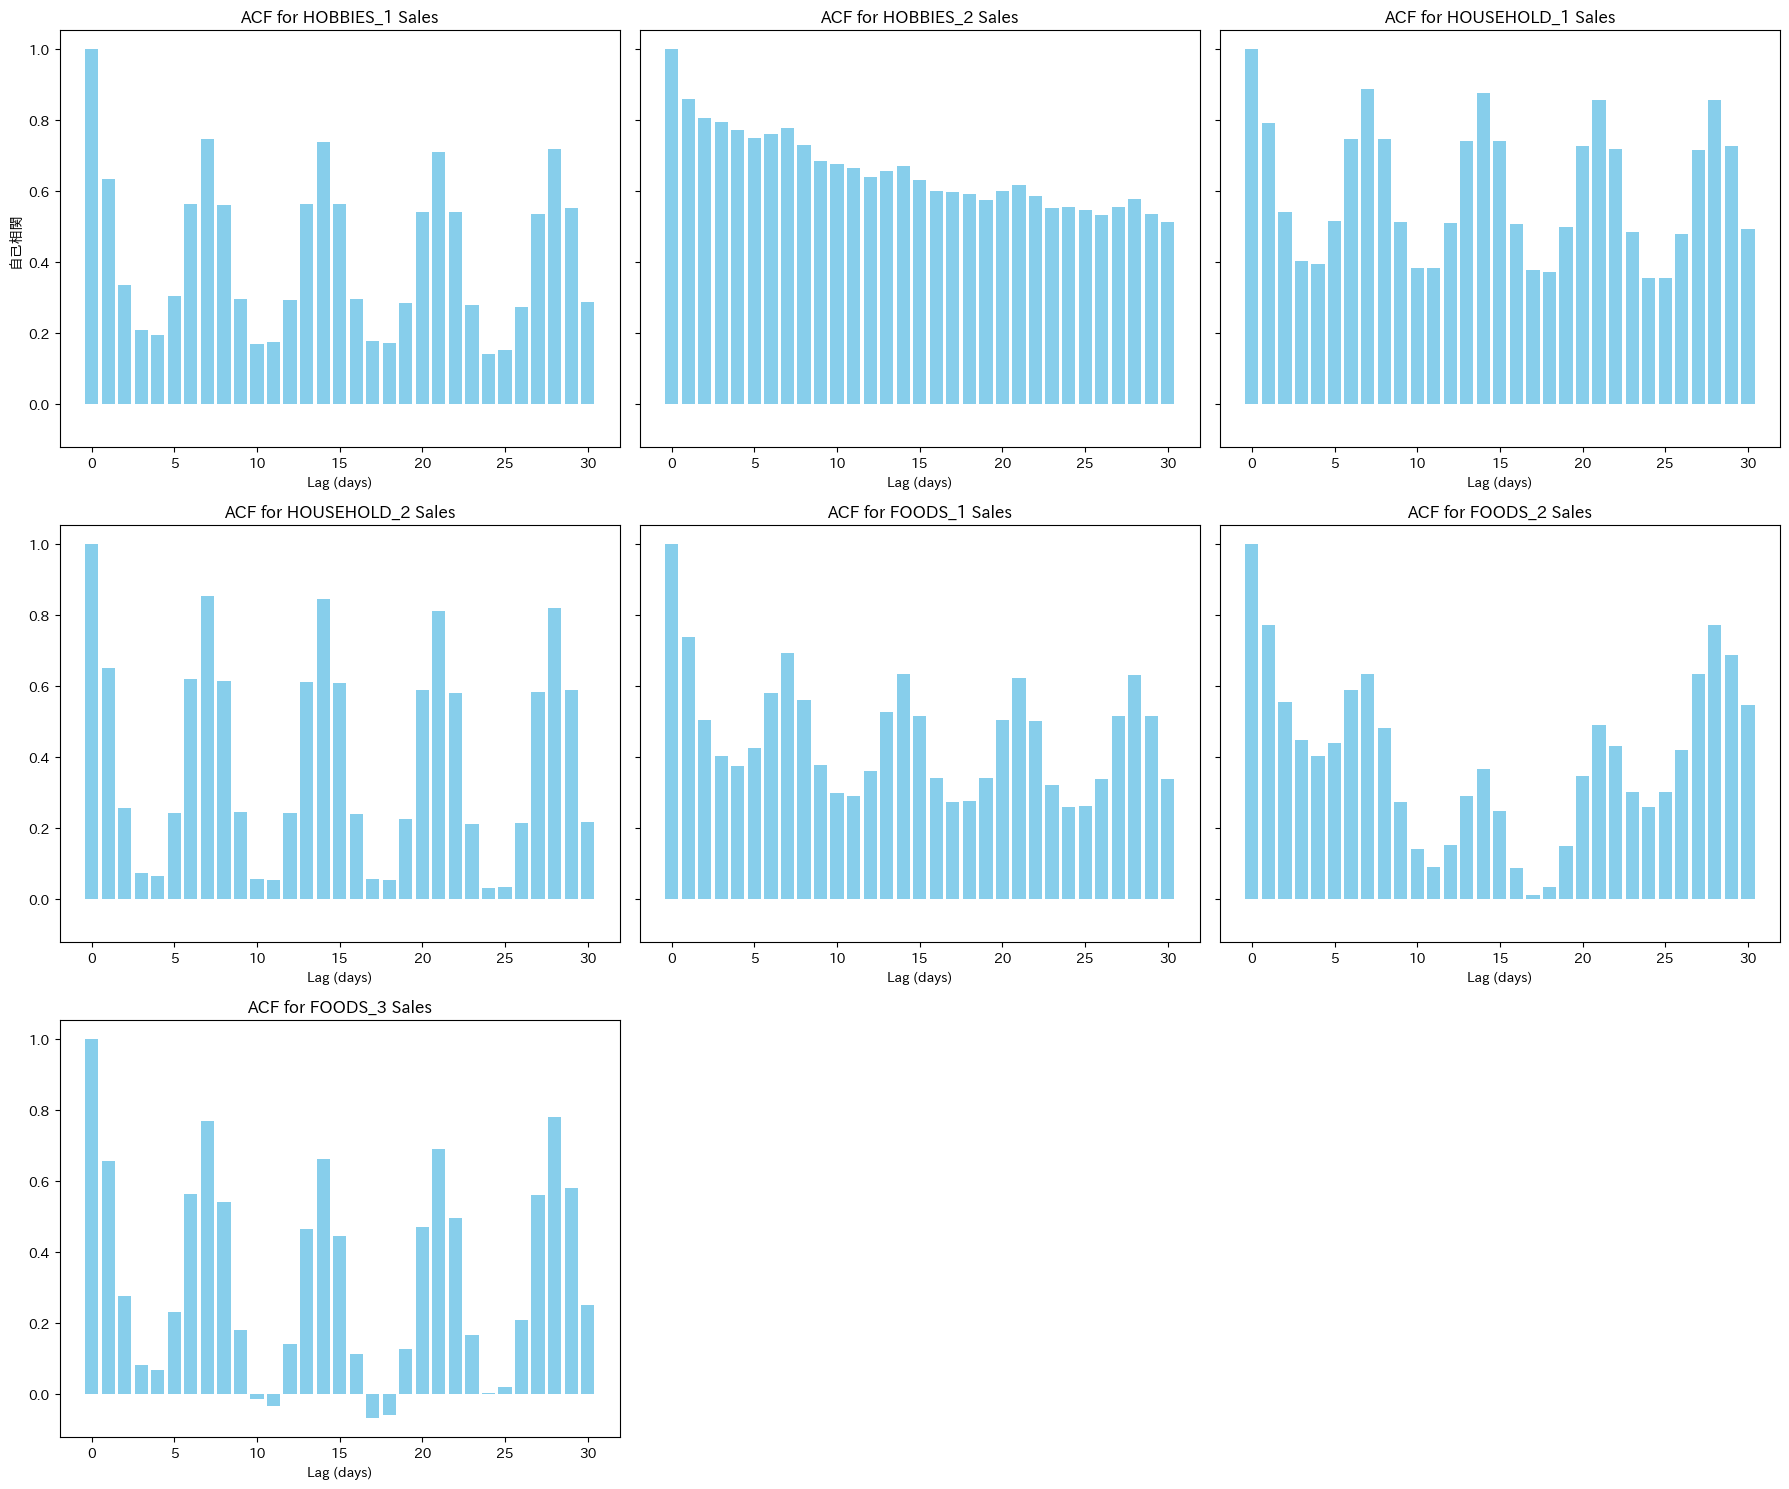

In [31]:
# sales_train_long から dept_id ごとに売上を集計
df_3 = sales_train_long.groupby(['date', 'dept_id'])['sales'].sum().reset_index()

# 分析対象の部門リスト（カテゴリー）
categories = ['HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS_1', 'FOODS_2', 'FOODS_3']
lags = 30  # 30日間のラグ

# グラフ描画のために行数と列数を設定 (カテゴリ数に応じて自動調整)
rows = int(np.ceil(len(categories) / 3))  # 3列に並べる
fig, axes = plt.subplots(rows, 3, figsize=(18, 5 * rows), sharey=True)

# `axes` を1Dリストに変換（axes.ndimが1の場合はそのまま）
if axes.ndim == 2:
    axes = axes.flatten()
else:
    axes = np.array(axes)  # 1Dの場合はそのまま

# 各カテゴリ（部門）ごとに処理を実行
for i, category in enumerate(categories):
    
    # 部門ごとにデータを抽出し、dateでインデックスを設定
    df_dept = df_3[df_3['dept_id'] == category].set_index('date')

    # 自己相関を計算
    acf_values = acf(df_dept['sales'], nlags=lags, fft=True)

    # 自己相関のプロットのプロットを作成
    axes[i].bar(range(len(acf_values)), acf_values, color='skyblue')
    axes[i].set_xlabel("Lag (days)")
    axes[i].set_title(f"ACF for {category} Sales")

# 左端のグラフに共通のYラベルを設定
axes[0].set_ylabel("自己相関")

# 余分な空白のグラフを削除
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# レイアウト調整
plt.tight_layout()
plt.show()

In [32]:
# ラグ（遅れ）のリスト。28日と56日の遅れを使用
LAGS = [28, 56]

# 各ラグに対してループ処理を行う
for lag in LAGS:
    # salesデータを`id`ごとにグループ化し、指定された遅れ（lag）だけシフトさせて新しい列を作成
    sales_train_long[f'lag_{lag}'] = sales_train_long.groupby('id')['sales'].shift(lag)
    
    # 欠損値（NaN）があれば0で埋める
    sales_train_long[f'lag_{lag}'].fillna(0, inplace=True)

In [33]:
# 移動平均を計算するウィンドウサイズのリスト。28日と56日を使用
WINDOWS = [28, 56]

# 各ウィンドウサイズについてループ処理
for window in WINDOWS:
    # `id`（商品）ごとにグループ化し、sales列に対してshift(28)を行い、移動平均を計算
    sales_train_long[f'rolling_mean_{window}'] = sales_train_long.groupby('id')['sales'].transform(lambda x: x.shift(28).rolling(window).mean())
    # 計算結果にNaN（欠損値）が含まれているので、それらを0で埋める
    sales_train_long[f'rolling_mean_{window}'] .fillna(0, inplace=True)

In [34]:
#データを表示
sales_train_long

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wday,...,event_name_1,event_type_1,event_name_2,event_type_2,wm_yr_wk,sell_price,lag_28,lag_56,rolling_mean_28,rolling_mean_56
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,1,...,NaN,NaN,NaN,NaN,11101,NaN,0.0,0.0,0.000000,0.000000
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,1,...,NaN,NaN,NaN,NaN,11101,NaN,0.0,0.0,0.000000,0.000000
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,1,...,NaN,NaN,NaN,NaN,11101,NaN,0.0,0.0,0.000000,0.000000
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,1,...,NaN,NaN,NaN,NaN,11101,NaN,0.0,0.0,0.000000,0.000000
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,1,...,NaN,NaN,NaN,NaN,11101,NaN,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59181085,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1941,1,2016-05-22,2,...,NaN,NaN,NaN,NaN,11617,2.980469,1.0,0.0,0.214286,0.232143
59181086,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,1941,0,2016-05-22,2,...,NaN,NaN,NaN,NaN,11617,2.480469,0.0,0.0,0.321429,0.160714
59181087,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,1941,2,2016-05-22,2,...,NaN,NaN,NaN,NaN,11617,3.980469,0.0,1.0,0.892857,1.071429
59181088,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,1941,0,2016-05-22,2,...,NaN,NaN,NaN,NaN,11617,1.280273,3.0,4.0,0.928571,1.089286


In [35]:
# pandasの表示設定を変更し、最大表示行数を200に設定
pd.set_option("display.max_rows", 200)
# calendarデータフレームから特定の列（イベント情報）を抽出
# すべてのイベント列（event_name_1, event_type_1, event_name_2, event_type_2）が欠損している行を削除
calendar[['event_name_1','event_type_1','event_name_2','event_type_2']].dropna(how='all')

,event_name_1,event_type_1,event_name_2,event_type_2
8,SuperBowl,Sporting,NaN,NaN
16,ValentinesDay,Cultural,NaN,NaN
23,PresidentsDay,National,NaN,NaN
39,LentStart,Religious,NaN,NaN
46,LentWeek2,Religious,NaN,NaN
47,StPatricksDay,Cultural,NaN,NaN
50,Purim End,Religious,NaN,NaN
85,OrthodoxEaster,Religious,Easter,Cultural
87,Pesach End,Religious,NaN,NaN
96,Cinco De Mayo,Cultural,NaN,NaN


In [36]:
# 'event_type_1'（イベントのタイプ）と'cat_id'（商品カテゴリー）でグループ化し、各グループの売上（'sales'）を合計
bar_2 = sales_train_long.groupby(['event_type_1','cat_id'])['sales'].sum().reset_index()
# bar_2の表示
bar_2

,event_type_1,cat_id,sales
0,Cultural,FOODS,892947
1,Cultural,HOBBIES,117558
2,Cultural,HOUSEHOLD,274083
3,National,FOODS,1051624
4,National,HOBBIES,125577
5,National,HOUSEHOLD,325183
6,Religious,FOODS,1276396
7,Religious,HOBBIES,174094
8,Religious,HOUSEHOLD,408527
9,Sporting,FOODS,405483


In [37]:
# sales_train_longデータフレームから、特定の列（'id', 'd', 'wday', 'event_name_1', 'event_type_1', 'lag_28', 'lag_56', 'rolling_mean_28', 'rolling_mean_56', 'sales'）を抽出
train = sales_train_long[['id','d','wday','event_name_1','event_type_1','lag_28','lag_56','rolling_mean_28','rolling_mean_56','sales']]

In [38]:
# trainデータの表示
train

,id,d,wday,event_name_1,event_type_1,lag_28,lag_56,rolling_mean_28,rolling_mean_56,sales
0,HOBBIES_1_001_CA_1_evaluation,1,1,NaN,NaN,0.0,0.0,0.000000,0.000000,0
1,HOBBIES_1_002_CA_1_evaluation,1,1,NaN,NaN,0.0,0.0,0.000000,0.000000,0
2,HOBBIES_1_003_CA_1_evaluation,1,1,NaN,NaN,0.0,0.0,0.000000,0.000000,0
3,HOBBIES_1_004_CA_1_evaluation,1,1,NaN,NaN,0.0,0.0,0.000000,0.000000,0
4,HOBBIES_1_005_CA_1_evaluation,1,1,NaN,NaN,0.0,0.0,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...
59181085,FOODS_3_823_WI_3_evaluation,1941,2,NaN,NaN,1.0,0.0,0.214286,0.232143,1
59181086,FOODS_3_824_WI_3_evaluation,1941,2,NaN,NaN,0.0,0.0,0.321429,0.160714,0
59181087,FOODS_3_825_WI_3_evaluation,1941,2,NaN,NaN,0.0,1.0,0.892857,1.071429,2
59181088,FOODS_3_826_WI_3_evaluation,1941,2,NaN,NaN,3.0,4.0,0.928571,1.089286,0


In [39]:
# 'id'列に'evaluation'という文字列を含む行だけをフィルタリングして、新しいデータフレームsub_evaを作成
sub_eva = sub[sub['id'].str.contains('evaluation')]

In [40]:
# 'sub_eva'データフレームをmelt（長い形式に変換）して、'id'を保持し、'F1'〜'F28'の列を行に変換
submission_long_eva = sub_eva.melt(id_vars=['id'], value_vars=[f'F{i}' for i in range(1, 29)],
                         var_name='d', value_name='sales')

# 'd'列の値（例: 'F1', 'F2'）から'F'を削除して整数型に変換
submission_long_eva['d'] = submission_long_eva['d'].str.replace('F', '').astype(int)

# 'd'列の値を、日付として1942年1月1日からの日数に変換
# 1942年1月1日が'd=1'に対応し、'd'の値が増加する
submission_long_eva['d'] = 1942 + submission_long_eva['d'] - 1

# 結果を表示
submission_long_eva

,id,d,sales
0,HOBBIES_1_001_CA_1_evaluation,1942,0
1,HOBBIES_1_002_CA_1_evaluation,1942,0
2,HOBBIES_1_003_CA_1_evaluation,1942,0
3,HOBBIES_1_004_CA_1_evaluation,1942,0
4,HOBBIES_1_005_CA_1_evaluation,1942,0
...,...,...,...
853715,FOODS_3_823_WI_3_evaluation,1969,0
853716,FOODS_3_824_WI_3_evaluation,1969,0
853717,FOODS_3_825_WI_3_evaluation,1969,0
853718,FOODS_3_826_WI_3_evaluation,1969,0


In [41]:
# calendarデータフレームと'merge'し、'd'列をキーにして、イベント名と曜日を結合
submission_long_eva = submission_long_eva.merge(calendar[['d','event_name_1','event_type_1','wday']],on='d',how='left')

## 新しい列を追加し、初期値を0に設定
# これらの列は後で予測のために計算される（たとえば、28日または56日の遅延や移動平均など）
submission_long_eva = submission_long_eva.assign(
    lag_28=0,
    lag_56=0,
    rolling_mean_28=0,
    rolling_mean_56=0,
)

# 結果を表示
submission_long_eva

,id,d,sales,event_name_1,event_type_1,wday,lag_28,lag_56,rolling_mean_28,rolling_mean_56
0,HOBBIES_1_001_CA_1_evaluation,1942,0,NaN,NaN,3,0,0,0,0
1,HOBBIES_1_002_CA_1_evaluation,1942,0,NaN,NaN,3,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,1942,0,NaN,NaN,3,0,0,0,0
3,HOBBIES_1_004_CA_1_evaluation,1942,0,NaN,NaN,3,0,0,0,0
4,HOBBIES_1_005_CA_1_evaluation,1942,0,NaN,NaN,3,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
853715,FOODS_3_823_WI_3_evaluation,1969,0,NBAFinalsEnd,Sporting,2,0,0,0,0
853716,FOODS_3_824_WI_3_evaluation,1969,0,NBAFinalsEnd,Sporting,2,0,0,0,0
853717,FOODS_3_825_WI_3_evaluation,1969,0,NBAFinalsEnd,Sporting,2,0,0,0,0
853718,FOODS_3_826_WI_3_evaluation,1969,0,NBAFinalsEnd,Sporting,2,0,0,0,0


In [42]:
#　trainデータとtestデータの列を統一
test= submission_long_eva[train.columns]

In [43]:
# testデータの表示
test

,id,d,wday,event_name_1,event_type_1,lag_28,lag_56,rolling_mean_28,rolling_mean_56,sales
0,HOBBIES_1_001_CA_1_evaluation,1942,3,NaN,NaN,0,0,0,0,0
1,HOBBIES_1_002_CA_1_evaluation,1942,3,NaN,NaN,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,1942,3,NaN,NaN,0,0,0,0,0
3,HOBBIES_1_004_CA_1_evaluation,1942,3,NaN,NaN,0,0,0,0,0
4,HOBBIES_1_005_CA_1_evaluation,1942,3,NaN,NaN,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
853715,FOODS_3_823_WI_3_evaluation,1969,2,NBAFinalsEnd,Sporting,0,0,0,0,0
853716,FOODS_3_824_WI_3_evaluation,1969,2,NBAFinalsEnd,Sporting,0,0,0,0,0
853717,FOODS_3_825_WI_3_evaluation,1969,2,NBAFinalsEnd,Sporting,0,0,0,0,0
853718,FOODS_3_826_WI_3_evaluation,1969,2,NBAFinalsEnd,Sporting,0,0,0,0,0


In [44]:
# 'sales'を別の変数に保存
train_y = train['sales']

In [45]:
# trainデータの行数を取得
ntrain = train.shape[0]

# testデータの行数を取得
ntest = test.shape[0]

# trainデータとtestデータを縦に結合（axis=0）し、1つのデータフレームにする
df_combined = pd.concat([train, test], axis=0) 

In [46]:
#結合データの結果を表示
df_combined

,id,d,wday,event_name_1,event_type_1,lag_28,lag_56,rolling_mean_28,rolling_mean_56,sales
0,HOBBIES_1_001_CA_1_evaluation,1,1,NaN,NaN,0.0,0.0,0.0,0.0,0
1,HOBBIES_1_002_CA_1_evaluation,1,1,NaN,NaN,0.0,0.0,0.0,0.0,0
2,HOBBIES_1_003_CA_1_evaluation,1,1,NaN,NaN,0.0,0.0,0.0,0.0,0
3,HOBBIES_1_004_CA_1_evaluation,1,1,NaN,NaN,0.0,0.0,0.0,0.0,0
4,HOBBIES_1_005_CA_1_evaluation,1,1,NaN,NaN,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...
853715,FOODS_3_823_WI_3_evaluation,1969,2,NBAFinalsEnd,Sporting,0.0,0.0,0.0,0.0,0
853716,FOODS_3_824_WI_3_evaluation,1969,2,NBAFinalsEnd,Sporting,0.0,0.0,0.0,0.0,0
853717,FOODS_3_825_WI_3_evaluation,1969,2,NBAFinalsEnd,Sporting,0.0,0.0,0.0,0.0,0
853718,FOODS_3_826_WI_3_evaluation,1969,2,NBAFinalsEnd,Sporting,0.0,0.0,0.0,0.0,0


In [47]:
# 28日および56日分のラグ（遅延）を計算
LAGS = [28, 56]
# 各ラグに対して処理を行う
for lag in LAGS:
    # 'id' ごとにグループ化して、'sales'の値を指定したラグ分シフト
    df_combined[f'lag_{lag}'] = df_combined.groupby('id')['sales'].shift(lag)
    # シフトされた結果、欠損値が発生するため、欠損値は0で埋める    
    df_combined[f'lag_{lag}'].fillna(0, inplace=True)

In [48]:
# 28日および56日間の移動平均を計算
WINDOWS = [28, 56]
# 各ウィンドウに対して処理を行う
for window in WINDOWS:
    # 'id'ごとにグループ化して、'sales'の値を28日シフトした後、指定されたウィンドウ（28日または56日）の移動平均を計算
    df_combined[f'rolling_mean_{window}'] = df_combined.groupby('id')['sales'].transform(lambda x: x.shift(28).rolling(window).mean())
    # 計算結果で発生する欠損値（NaN）は0で埋める
    df_combined[f'rolling_mean_{window}'] .fillna(0, inplace=True)

In [49]:
# 結合データの情報を表示
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60034810 entries, 0 to 853719
Data columns (total 10 columns):
 #   Column           Dtype   
---  ------           -----   
 0   id               object  
 1   d                int64   
 2   wday             int8    
 3   event_name_1     category
 4   event_type_1     category
 5   lag_28           float64 
 6   lag_56           float64 
 7   rolling_mean_28  float64 
 8   rolling_mean_56  float64 
 9   sales            int16   
dtypes: category(2), float64(4), int16(1), int64(1), int8(1), object(1)
memory usage: 3.4+ GB


In [50]:
# idをcategoryデータに変換
df_combined['id'] = df_combined['id'].astype('category')

In [51]:
# 結合データから'sales'列を削除
df_combined = df_combined.drop(['sales'],axis=1)

In [52]:
# 訓練データ (train) とテストデータ (test) を分割する
# 最初のntrain行を訓練データとしてtrainに格納
train = df_combined[:ntrain]

# ntrain行目以降をテストデータとしてtestに格納
test = df_combined[ntrain:]

In [53]:
# trainデータを表示
train

,id,d,wday,event_name_1,event_type_1,lag_28,lag_56,rolling_mean_28,rolling_mean_56
0,HOBBIES_1_001_CA_1_evaluation,1,1,NaN,NaN,0.0,0.0,0.000000,0.000000
1,HOBBIES_1_002_CA_1_evaluation,1,1,NaN,NaN,0.0,0.0,0.000000,0.000000
2,HOBBIES_1_003_CA_1_evaluation,1,1,NaN,NaN,0.0,0.0,0.000000,0.000000
3,HOBBIES_1_004_CA_1_evaluation,1,1,NaN,NaN,0.0,0.0,0.000000,0.000000
4,HOBBIES_1_005_CA_1_evaluation,1,1,NaN,NaN,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
59181085,FOODS_3_823_WI_3_evaluation,1941,2,NaN,NaN,1.0,0.0,0.214286,0.232143
59181086,FOODS_3_824_WI_3_evaluation,1941,2,NaN,NaN,0.0,0.0,0.321429,0.160714
59181087,FOODS_3_825_WI_3_evaluation,1941,2,NaN,NaN,0.0,1.0,0.892857,1.071429
59181088,FOODS_3_826_WI_3_evaluation,1941,2,NaN,NaN,3.0,4.0,0.928571,1.089286


In [54]:
# testデータを表示
test

,id,d,wday,event_name_1,event_type_1,lag_28,lag_56,rolling_mean_28,rolling_mean_56
0,HOBBIES_1_001_CA_1_evaluation,1942,3,NaN,NaN,0.0,1.0,0.928571,0.982143
1,HOBBIES_1_002_CA_1_evaluation,1942,3,NaN,NaN,0.0,1.0,0.035714,0.196429
2,HOBBIES_1_003_CA_1_evaluation,1942,3,NaN,NaN,0.0,0.0,0.571429,0.553571
3,HOBBIES_1_004_CA_1_evaluation,1942,3,NaN,NaN,0.0,0.0,1.821429,1.857143
4,HOBBIES_1_005_CA_1_evaluation,1942,3,NaN,NaN,1.0,1.0,1.357143,1.232143
...,...,...,...,...,...,...,...,...,...
853715,FOODS_3_823_WI_3_evaluation,1969,2,NBAFinalsEnd,Sporting,1.0,1.0,0.642857,0.428571
853716,FOODS_3_824_WI_3_evaluation,1969,2,NBAFinalsEnd,Sporting,0.0,0.0,0.285714,0.303571
853717,FOODS_3_825_WI_3_evaluation,1969,2,NBAFinalsEnd,Sporting,2.0,0.0,0.785714,0.839286
853718,FOODS_3_826_WI_3_evaluation,1969,2,NBAFinalsEnd,Sporting,0.0,3.0,1.321429,1.125000


In [55]:
# lightgbmをインポート
import lightgbm as lgb

# 訓練データ (X_train) をtrainに設定
X_train = train

# train_yは訓練データのターゲット変数（販売数）であると仮定
lgb_train = lgb.Dataset(X_train, label=train_y)

# モデルのパラメータ設定
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1,
}

# モデルの学習を行う
model = lgb.train(params, lgb_train, num_boost_round=1000)

# テストデータに対する予測を行う
y_pred = model.predict(test)

In [56]:
# 予測結果 y_pred の統計的要約を表示
pd.Series(y_pred).describe()

count    853720.000000
mean          1.464632
std           2.969673
min          -5.941616
25%           0.356376
50%           0.681137
75%           1.429817
max         152.611677
dtype: float64

In [57]:
# 予測結果 y_pred に対して、値が 0.5 より小さい場合は 0 に、それ以外は四捨五入して整数に変換
y_pred = np.where(y_pred < 0.5, 0, np.round(y_pred))

In [58]:
# 予測結果 y_pred を DataFrame に変換し、カラム名を 'sales' に設定
final_pred= pd.DataFrame(y_pred,columns=['sales'])

# 'sales' カラムの要約統計量を表示
final_pred.describe()

,sales
count,853720.000000
mean,1.406937
std,3.011543
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,153.000000


In [59]:
# 'test' と 'final_pred' を横に結合（列方向に結合）して、新しい DataFrame 'test_eva' を作成
test_eva = pd.concat([test, final_pred], axis=1) 

# 'wday', 'event_name_1', 'event_type_1', 'lag_28', 'lag_56', 'rolling_mean_28', 'rolling_mean_56' を削除
test_eva = test_eva.drop(['wday','event_name_1','event_type_1','lag_28','lag_56','rolling_mean_28','rolling_mean_56'],axis=1)

# 最終的な予測結果を含む 'test_eva' を表示
test_eva

,id,d,sales
0,HOBBIES_1_001_CA_1_evaluation,1942,1.0
1,HOBBIES_1_002_CA_1_evaluation,1942,0.0
2,HOBBIES_1_003_CA_1_evaluation,1942,1.0
3,HOBBIES_1_004_CA_1_evaluation,1942,2.0
4,HOBBIES_1_005_CA_1_evaluation,1942,1.0
...,...,...,...
853715,FOODS_3_823_WI_3_evaluation,1969,1.0
853716,FOODS_3_824_WI_3_evaluation,1969,0.0
853717,FOODS_3_825_WI_3_evaluation,1969,1.0
853718,FOODS_3_826_WI_3_evaluation,1969,1.0


In [60]:
# 'test_eva' の 'id' と 'd' 列をインデックスとして設定し、'sales' 列をユニークな 'id' ごとに日別に展開（unstack）
test_eva_unstack = test_eva.set_index(["id","d"])["sales"].unstack().reset_index()

# 'test_eva_unstack' の列名を設定
test_eva_unstack.columns = ["id"] + [f"F{i+1}" for i in range(len(test_eva_unstack.columns) - 1)]

# 'id' 列を基準に再インデックスを行い、'test_eva' の 'id' に一致するように並べ替え
test_eva_unstack = test_eva_unstack.set_index("id").reindex(test_eva["id"].unique()).reset_index()

# 最終的な予測結果（test_eva_unstack）を表示
test_eva_unstack

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_evaluation,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,...,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,HOBBIES_1_002_CA_1_evaluation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,HOBBIES_1_003_CA_1_evaluation,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,HOBBIES_1_004_CA_1_evaluation,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0
4,HOBBIES_1_005_CA_1_evaluation,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,...,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
30486,FOODS_3_824_WI_3_evaluation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30487,FOODS_3_825_WI_3_evaluation,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
30488,FOODS_3_826_WI_3_evaluation,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0


In [61]:
# 'sales_train' データフレームから 'id' と特定の範囲の列（d_1914 から d_1941まで）を選択してフィルタリング
sales_train_filtered = sales_train.filter(items=["id"] + [f"d_{i}" for i in range(1914, 1942)])

# フィルタリングされたデータを表示
sales_train_filtered

,id,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,0,0,0,2,0,3,5,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,0,1,0,0,0,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,0,0,1,1,0,2,1,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,0,0,1,2,4,1,6,4,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,1,0,2,3,1,0,3,2,3,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,0,0,0,2,2,0,0,0,2,...,1,0,3,0,1,1,0,0,1,1
30486,FOODS_3_824_WI_3_evaluation,0,1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
30487,FOODS_3_825_WI_3_evaluation,0,0,1,1,0,2,1,1,0,...,0,0,1,2,0,1,0,1,0,2
30488,FOODS_3_826_WI_3_evaluation,1,3,0,1,2,1,0,2,1,...,1,1,1,4,6,0,1,1,1,0


In [62]:
# d_1914 ~ d_1941 の列名を F1 ~ F28 に変更
sales_train_filtered.columns = ["id"] + [f"F{i+1}" for i in range(28)]

# id 列の 'evaluation' を 'validation' に置換
sales_train_filtered["id"] = sales_train_filtered["id"].apply(lambda x: x.replace("evaluation", "validation") if isinstance(x, str) else x)

# フィルタリングされたデータを表示
sales_train_filtered

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,2,0,3,5,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_validation,0,1,0,0,0,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,1,1,0,2,1,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_validation,0,0,1,2,4,1,6,4,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_validation,1,0,2,3,1,0,3,2,3,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,0,0,0,2,2,0,0,0,2,...,1,0,3,0,1,1,0,0,1,1
30486,FOODS_3_824_WI_3_validation,0,1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
30487,FOODS_3_825_WI_3_validation,0,0,1,1,0,2,1,1,0,...,0,0,1,2,0,1,0,1,0,2
30488,FOODS_3_826_WI_3_validation,1,3,0,1,2,1,0,2,1,...,1,1,1,4,6,0,1,1,1,0


In [63]:
# sales_train_filtered（過去のトレーニングデータ）と test_eva_unstack（予測結果）を縦方向に連結
sales_vali_eva = pd.concat([sales_train_filtered, test_eva_unstack], axis=0) 

# 結果を表示
sales_vali_eva

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.0,0.0,0.0,2.0,0.0,3.0,5.0,0.0,0.0,...,2.0,4.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,1.0
1,HOBBIES_1_002_CA_1_validation,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,HOBBIES_1_003_CA_1_validation,0.0,0.0,1.0,1.0,0.0,2.0,1.0,0.0,0.0,...,1.0,0.0,2.0,0.0,0.0,0.0,2.0,3.0,0.0,1.0
3,HOBBIES_1_004_CA_1_validation,0.0,0.0,1.0,2.0,4.0,1.0,6.0,4.0,0.0,...,1.0,1.0,0.0,4.0,0.0,1.0,3.0,0.0,2.0,6.0
4,HOBBIES_1_005_CA_1_validation,1.0,0.0,2.0,3.0,1.0,0.0,3.0,2.0,3.0,...,0.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
30486,FOODS_3_824_WI_3_evaluation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30487,FOODS_3_825_WI_3_evaluation,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
30488,FOODS_3_826_WI_3_evaluation,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0


In [64]:
# sales_vali_eva データフレームを CSV ファイルとして保存
sales_vali_eva.to_csv('sales_vali_eva.csv', index=False)

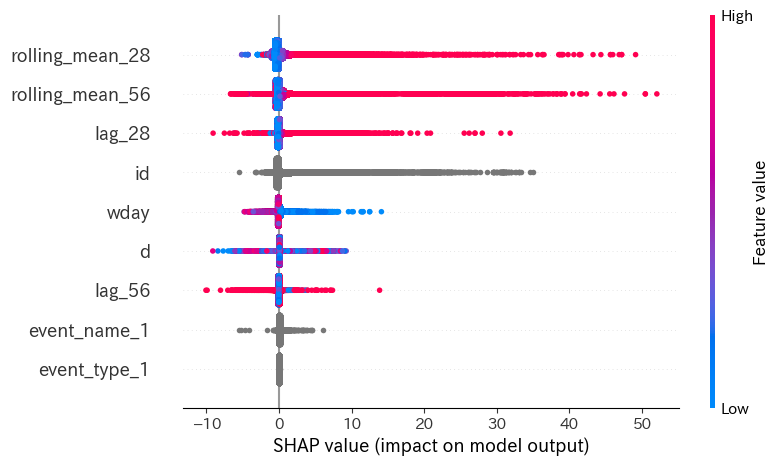

In [65]:
import shap
# shap.Explainer()にモデルを渡す
explainer = shap.TreeExplainer(model)

# explainerインスタンスに説明変数(特徴量)を渡す
shap_values = explainer(test)

# beeswarmをプロット
shap.plots.beeswarm(shap_values)